### Programming and critical analysis

Considering the `pd_speech.arff` dataset available:
- Using `sklearn`, considering a 10-fold stratified cross validation (`random=0`), plot the cumulative testing confusion matrices of kNN (uniform weights, k = 5, Euclidean distance) and Naïve Bayes (Gaussian assumption). Use all remaining classifier parameters as default.
- Using `scipy`, test the hypothesis “kNN is statistically superior to Naïve Bayes regarding accuracy”, asserting whether it is true.

knn > nb? pval= 0.0013168178284908261


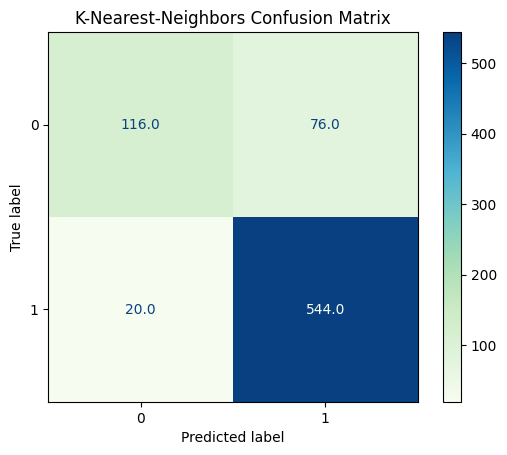

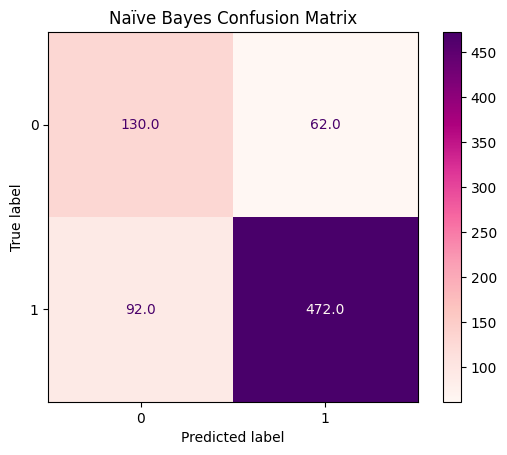

In [15]:
import pandas as pd
import numpy as np
from scipy.io.arff import loadarff
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from scipy.stats import ttest_rel

# Read the ARFF file and separate input from output data, to encode as numeric
data = loadarff('pd_speech.arff')
df = pd.DataFrame(data[0])
X = df.drop('class', axis=1)
y = LabelEncoder().fit_transform(df['class'])

# Create the stratified folds, classifiers, confusion matrices and accuracy lists
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='euclidean')
nb = GaussianNB()
knn_cm, nb_cm = np.zeros((2, 2)), np.zeros((2, 2))
knn_acc, nb_acc = ([] for i in range(2))
    
# Iterate over the folds
for train_indexes, test_indexes in skf.split(X, y):
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_indexes], X.iloc[test_indexes]
    y_train, y_test = y[train_indexes], y[test_indexes]
    # Scale the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # Fit the classifiers
    knn.fit(X_train, y_train)
    nb.fit(X_train, y_train)
    # Get the predicted output and compute the confusion matrices
    knn_pred, nb_pred = knn.predict(X_test), nb.predict(X_test)
    knn_cm += confusion_matrix(y_test, knn_pred)
    nb_cm += confusion_matrix(y_test, nb_pred)
    # Append the accuracy scores to the list
    knn_acc.append(accuracy_score(y_test, knn_pred))
    nb_acc.append(accuracy_score(y_test, nb_pred))

# Plot the confusion matrices
disp = ConfusionMatrixDisplay(confusion_matrix=knn_cm)
disp.plot(cmap='GnBu', values_format='')
disp.ax_.set_title('K-Nearest-Neighbors Confusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix=nb_cm)
disp.plot(cmap='RdPu', values_format='')
disp.ax_.set_title('Naïve Bayes Confusion Matrix')

# Compute the t-tests: is the kNN predictor better than the Naive Bayes one?
res = ttest_rel(knn_acc, nb_acc, alternative='greater')
print('knn > nb? pval=', res.pvalue)